In [1]:
###############################################################
#       Used inception_resnet_v2 to classify family pictures  #
#       Shawn Rajabzadeh Dec 25, 2017                         #
#       Initial release                                       #
#                                                             #
###############################################################

In [2]:
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import inception_preprocessing as pre
import tensorflow as tf
import numpy as np
import shutil, uuid, gc, json
import matplotlib.pyplot as plt
from os.path import *
from os import listdir, mkdir
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.cluster import k_means

%matplotlib inline

In [3]:
pictures_source_path = "D:\\pictures"
pictures_organized_folder = "D:\\pictures\\organized"


#Function definitions
def load_model():
    tf.reset_default_graph()
    slim = tf.contrib.slim
    height = 299
    width = 299
    channels = 3
    X = tf.placeholder(shape=[None, None, None, 3], dtype=tf.float32)
    X_processed = tf.map_fn(lambda x:pre.preprocess_for_eval(image=x, width=width, height=height), X)
    
    with slim.arg_scope(inception_resnet_v2_arg_scope()):
        inception_resnet_v2(X_processed, num_classes=1001,is_training=False)

    saver = tf.train.Saver()
    sess = tf.Session()
    saver.restore(sess, "inception_resnet_v2_2016_08_30.ckpt")
    graph = sess.graph
    mid_layer = graph.get_tensor_by_name("InceptionResnetV2/AuxLogits/Conv2d_2a_5x5/BatchNorm/FusedBatchNorm:0")
    mid_layer_a = tf.contrib.layers.flatten(mid_layer)
    
    return (sess, X, mid_layer_a)
    

def get_pic_paths(path_to_look, paths_to_return, jpg_only=True):
   
    for it in listdir(path_to_look):
        abs_path = "{}\\{}".format(path_to_look, it) 
        if(isdir(abs_path)==True):
            get_pic_paths(abs_path, paths_to_return)
        else:
            if(jpg_only==True and abs_path.upper().endswith(".JPG")):
                paths_to_return.append(abs_path)
            elif(jpg_only==False):
                paths_to_return.append(abs_path)
                
def open_and_scale_image(images_paths):
    processed_images = list()
    processed_paths = list()
    for image_path in images_paths:
        try:
            img = np.array(Image.open(image_path ,mode="r"))
            img = img / 255.
            img = np.expand_dims(img, axis=0)
            processed_images.append(img)
            processed_paths.append(image_path)
        except TypeError:
            print("Error processing {}".format(image_path))
    return(processed_paths, processed_images)

def predict(images, mid_layer_a):
    vectors = np.ndarray(shape=[len(images), 768])
    with sess.as_default():
        for i in range(len(images)):
            vectors[i,:] = sess.run(mid_layer_a, feed_dict={X:images[i]})
        return(vectors)



In [4]:


try:
    sess.close()
except NameError:
    None

sess, X, mid_layer_a = load_model()

image_paths = list()
get_pic_paths(path_to_look=pictures_source_path, paths_to_return=image_paths)

#To make it mutiple indexable
image_paths = np.array(image_paths)

#Breakdown to batches
indices = np.array_split(np.arange(len(image_paths)), int(len(image_paths)/10))

#Initialized results
vectors_values = list()
processed_paths_values = list()

#Run the bathes through model
for idx in indices:
    print("Doing indices {}", idx)
    processed_paths, image_batch = open_and_scale_image(images_paths=image_paths[idx])
    vectors = predict(image_batch, mid_layer_a)
    vectors_values.extend(vectors)
    processed_paths_values.extend(processed_paths)
    assert(len(processed_paths_values)==len(vectors_values))
assert(len(processed_paths_values)==len(vectors_values))

INFO:tensorflow:Restoring parameters from inception_resnet_v2_2016_08_30.ckpt
Doing indices {} [ 0  1  2  3  4  5  6  7  8  9 10]
Doing indices {} [11 12 13 14 15 16 17 18 19 20 21]
Doing indices {} [22 23 24 25 26 27 28 29 30 31 32]
Doing indices {} [33 34 35 36 37 38 39 40 41 42]
Doing indices {} [43 44 45 46 47 48 49 50 51 52]
Doing indices {} [53 54 55 56 57 58 59 60 61 62]
Doing indices {} [63 64 65 66 67 68 69 70 71 72]
Doing indices {} [73 74 75 76 77 78 79 80 81 82]
Doing indices {} [83 84 85 86 87 88 89 90 91 92]
Doing indices {} [ 93  94  95  96  97  98  99 100 101 102]
Doing indices {} [103 104 105 106 107 108 109 110 111 112]
Doing indices {} [113 114 115 116 117 118 119 120 121 122]
Doing indices {} [123 124 125 126 127 128 129 130 131 132]
Doing indices {} [133 134 135 136 137 138 139 140 141 142]
Doing indices {} [143 144 145 146 147 148 149 150 151 152]
Doing indices {} [153 154 155 156 157 158 159 160 161 162]
Doing indices {} [163 164 165 166 167 168 169 170 171 172]


In [5]:
#Reduce dimensionsality

tsne = TSNE(n_components=2)
low_dims = tsne.fit_transform(np.vstack(vectors_values))
k_means_model = k_means(X=low_dims, n_clusters=15)
k_means_clusters = k_means_model[1]


In [6]:
# Create organized directory and copy the pictures to coresponding directory

for c in np.unique(k_means_model[1]):
    mkdir("{}\\{}".format(pictures_organized_folder ,c))
    
for source_path, dest_folder_name in zip(processed_paths_values, k_means_clusters):
    file_name = "{}_{}".format(uuid.uuid1(), basename(source_path))
    dest_path = "{}\\{}\\{}".format(pictures_organized_folder, dest_folder_name, file_name)
    shutil.copy(source_path, dest_path)


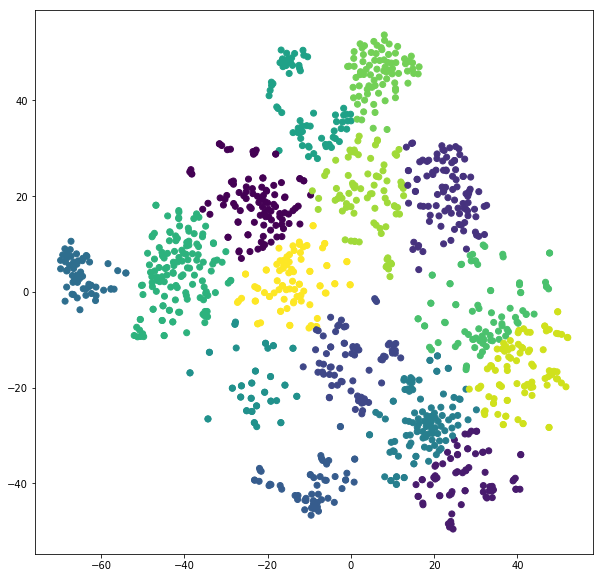

In [7]:
#Optional plot
plt.subplots(figsize=(10, 10))
plt.scatter(x=low_dims[:,0], y=low_dims[:,1], c=k_means_clusters)
plt.show()